In [9]:
# Imports
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import json



In [17]:
# Input Area
MERGED_RESULT_FILE_NAME = 'issac1_20211012125543.csv'


In [18]:
# Read merged backtest results from csv
df_original = pd.read_csv('./merged_results/'+MERGED_RESULT_FILE_NAME)
df_original.head()
# Load extra info into dataframe as columes
dict_extra = df_original['extra'].to_dict()
for key in dict_extra.keys():
    extra_str = dict_extra[key].replace("'",'"')
    dict_extra[key] = json.loads(extra_str)
extra_df = pd.DataFrame.from_dict(dict_extra,orient='index')
df_original = pd.concat([df_original, extra_df], axis=1)

In [19]:
'''
Filters which is processed before analyse
'''
df = df_original.copy(deep = True)
# Price filter Template
df = df[(df['open_price'] < 100) & (df['open_price'] >= 5)]
# Opendate filter Template
df = df[df['open_date'] > '2019-06-01 00:00:00']

# Stocks name filter
unwanted_list = ['AAPL_US']
df = df[~df['symbol'].isin(unwanted_list)]
df

In [13]:
'''
Basic Analyse
'''
GRAINESS = 5
df['entry_price_in_grainess'] =(df['open_price']/GRAINESS).astype(int) * GRAINESS
grouped = df.groupby('entry_price_in_grainess')
profit_distribute = grouped[['profit']].sum()
true_profit_distribute = grouped[['true_profit']].sum()
# Profit cumsum
df['pnl_cum_true'] = df['true_profit'].cumsum()
df['pnl_cum'] = df['profit'].cumsum()

# Margin cumsum
margin_event = []
for index, row in df.iterrows():
    event_temp = {
        "date":row['open_date'],
        "amount":abs(row["margin"])
    }
    margin_event.append(event_temp)
    event_temp = {
        "date":row['close_date'],
        "amount":0-abs(row["margin"])
    }
    margin_event.append(event_temp)
margin_event = sorted(margin_event, key=lambda k: k['date']) 
margin_df = pd.DataFrame(margin_event)
margin_df['margin_total'] = margin_df['amount'].cumsum()
margin_df = margin_df.set_index('date')
dict_margin_df = margin_df['margin_total'].to_dict()
df['margin_total'] = df['open_date'].map(dict_margin_df).fillna(method='ffill')
# Orders distribution in month-year category
df['open_date_month_and_year'] = df['open_date'].apply(lambda x:x[0:7])
df['open_date_month_and_year_count'] = 1
month_and_year_distribute = df.groupby('open_date_month_and_year')[['profit','open_date_month_and_year_count']].sum()


<AxesSubplot:xlabel='open_date'>

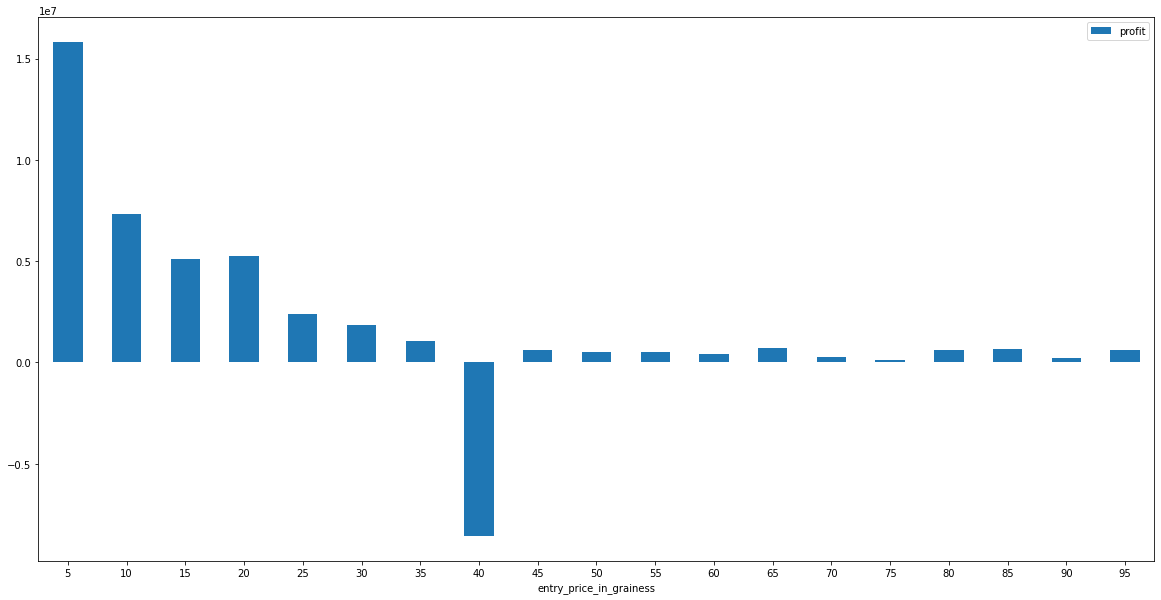

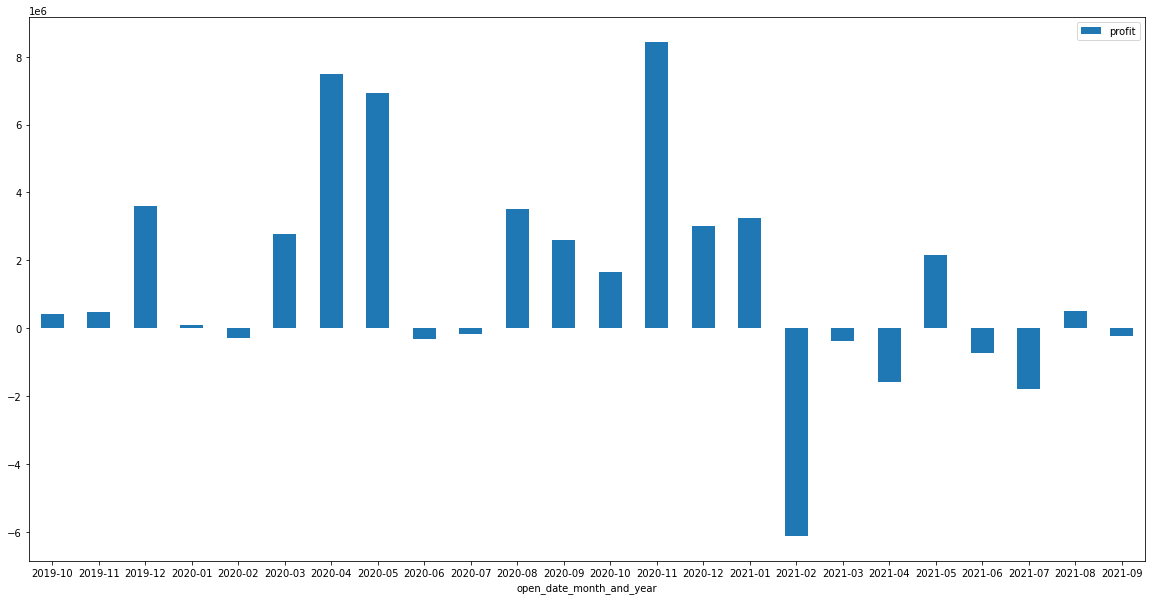

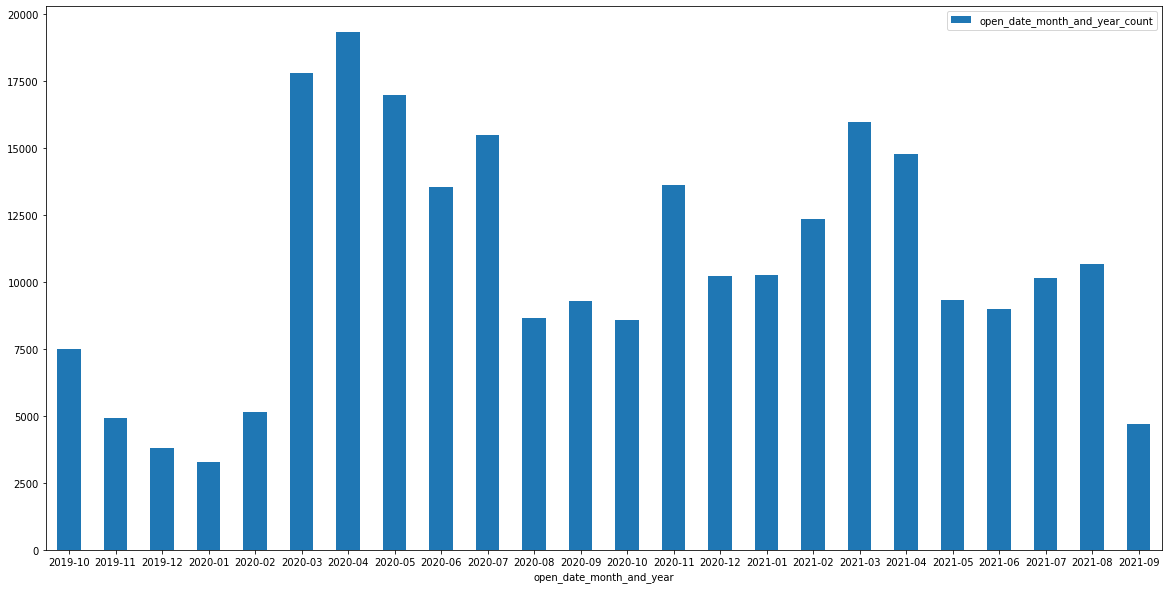

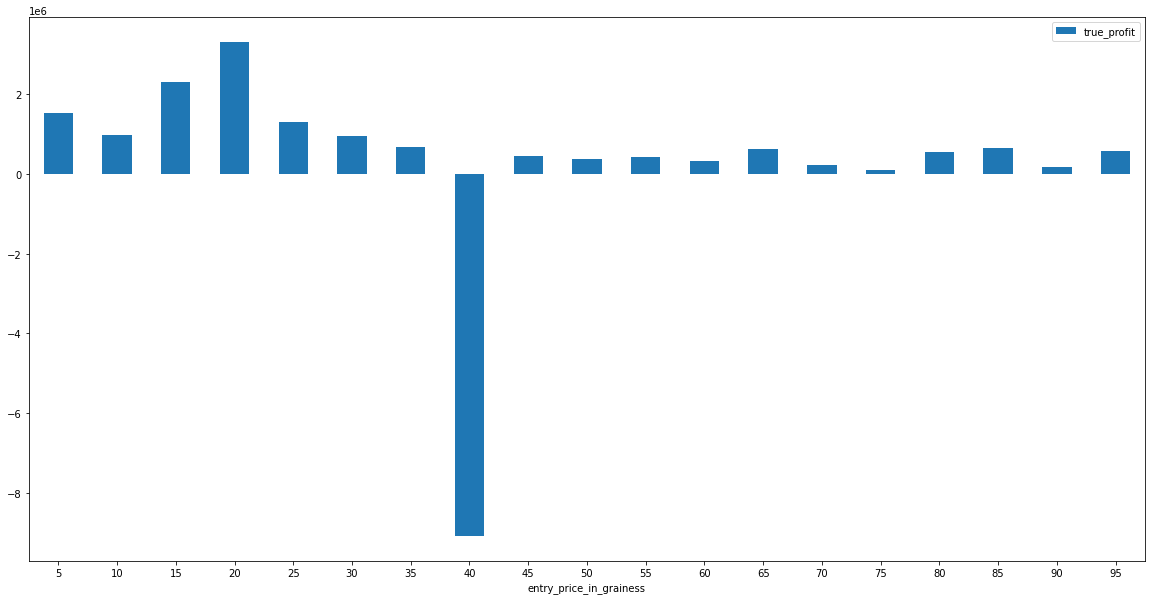

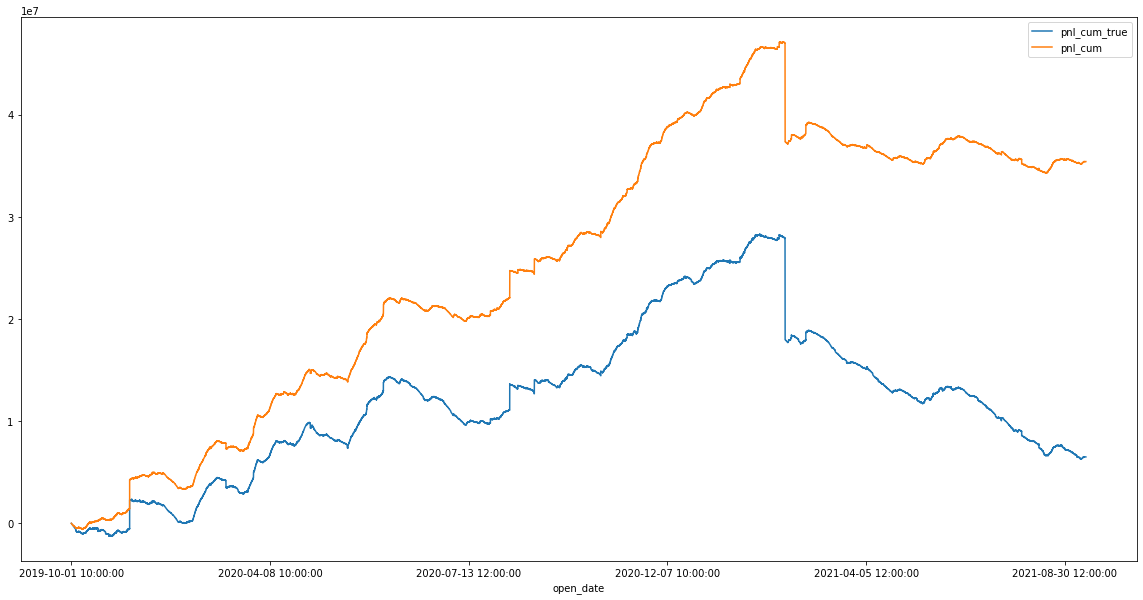

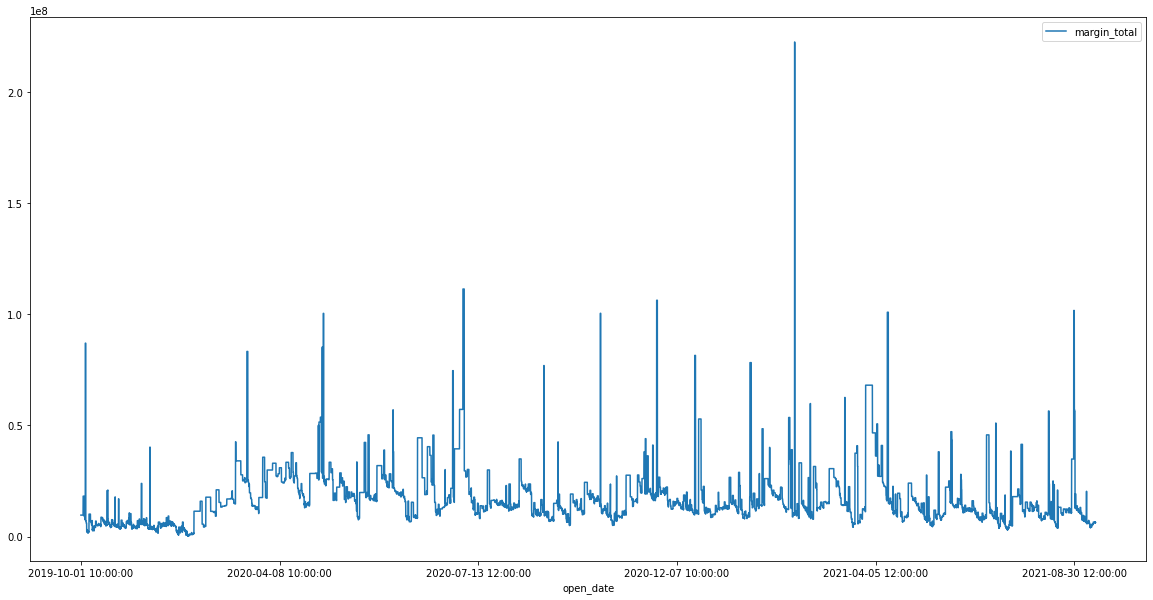

In [14]:
# Draw
profit_distribute.plot.bar( y='profit', rot=0,figsize=(20,10))
month_and_year_distribute.plot.bar( y='profit', rot=0,figsize=(20,10))
month_and_year_distribute.plot.bar( y='open_date_month_and_year_count', rot=0,figsize=(20,10))
true_profit_distribute.plot.bar( y='true_profit', rot=0,figsize=(20,10))
df.plot.line(x='open_date', y=['pnl_cum_true','pnl_cum'],figsize=(20,10))
df.plot.line(x='open_date', y=['margin_total'],figsize=(20,10))

In [15]:
# Print
print("====================Basic Info===================")
print("Total true profit",df['true_profit'].sum())
print("Avg win in perc",str(((df['close_price']-df['open_price'])/df['open_price']).mean() * 100) + '%')
print("Win rate",str(df[df['profit'] > 0].shape[0] / df.shape[0] * 100)+ '%' )
print("Total orders",df.shape[0])
print("Total commissions",df['commission'].sum())
print("Total profit",df['profit'].sum())
print("=========Order Distribution In Year-Month=========")
print(month_and_year_distribute.describe())

====================Basic Info===================
Total true profit 6495005.746499993
Avg win in perc 0.688622202306855%
Win rate 19.87143830840704%
Total orders 255286
Total commissions -28901595.468000002
Total profit 35396601.21449997
=========Order Distribution In Year-Month=========
             profit  open_date_month_and_year_count
count  2.400000e+01                       24.000000
mean   1.474858e+06                    10636.916667
std    3.193565e+06                     4569.816702
min   -6.121306e+06                     3270.000000
25%   -2.837364e+05                     8307.500000
50%    4.951574e+05                    10188.000000
75%    3.066154e+06                    13918.000000
max    8.431633e+06                    19322.000000


In [16]:
'''
Custom Analyse
'''


'\nCustom Analyse\n'